<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap07_mnist_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章：画像分類問題を解いてみよう
- 手書きの数字を1~9に分類するモデルを作成します

> 引用を追加

- 本Notebookのゴール感
  - Collaboratory上でのPythonの動かし方を体験する
  - コードを動かしながら画像解析に対する理解を深める

# Colab上でデータを確認しよう

## 必要なライブラリのインストール

In [ ]:
!pip install visualkeras==0.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.4 MB/s eta 0:00:00


## ライブラリのインポート

In [ ]:
# TensorFlowライブラリをtfという別名でインポートします
import tensorflow as tf

# ネットワーク（モデル）を構築するための「部品」をインポートします
# - Sequential: モデルを順に積み重ねるためのクラス
# - Conv2D: 2次元の畳み込み層を追加するためのクラス（画像の特徴を抽出）
# - ReLU: 活性化関数ReLUを適用するためのクラス（非線形性を導入）
# - MaxPooling2D: 最大プーリング層を追加するためのクラス（特徴マップのサイズを縮小）
# - Flatten: 多次元配列を1次元に変換するためのクラス（全結合層への入力を準備）
# - Dense: 全結合層を追加するためのクラス（ニューラルネットワークの基本層）
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのツールをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
import matplotlib.pyplot as plt
import visualkeras
import numpy as np

## GPUを選択

In [ ]:
import torch
# Google ColabでGPUを使う手順：
# 「ランタイム」→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPUに設定→保存
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


## 学習に使うデータの準備

### Datasetsの準備（[MNISTデータ](https://ja.wikipedia.org/wiki/MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9)のダウンロード）

torchvision.datasets.~を使うことですでに公開されているデータを取得することが可能  
torchvision.datasetsの詳細は[こちら](https://pytorch.org/vision/stable/datasets.html)  

# Kerasを使う

学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


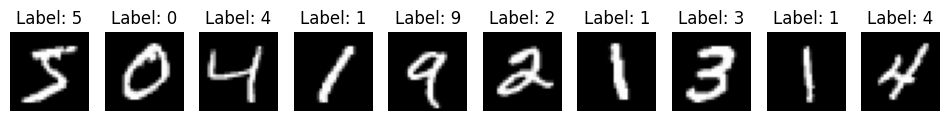

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# x_train = x_train / 255.0,
# x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから10個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=10)

In [ ]:
# 学習曲線を描画する関数を定義
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # 正確さをプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 損失をプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 784)               0         
                                                                 
 dense_34 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


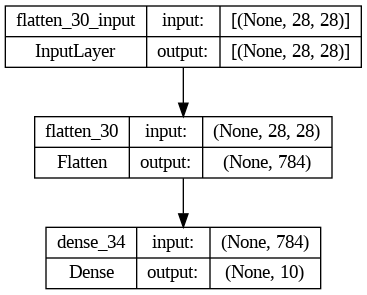

In [ ]:
# モデルの定義
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(10, activation='softmax')
])

# モデルのサマリーを表示
model.summary()

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.4261 - accuracy: 0.8777 - val_loss: 0.5863 - val_accuracy: 0.9059
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5229 - accuracy: 0.9279 - val_loss: 0.5442 - val_accuracy: 0.9346
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4189 - accuracy: 0.9433 - val_loss: 0.5203 - val_accuracy: 0.9450
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3418 - accuracy: 0.9519 - val_loss: 0.4885 - val_accuracy: 0.9460
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3188 - accuracy: 0.9561 - val_loss: 0.5083 - val_accuracy: 0.9488


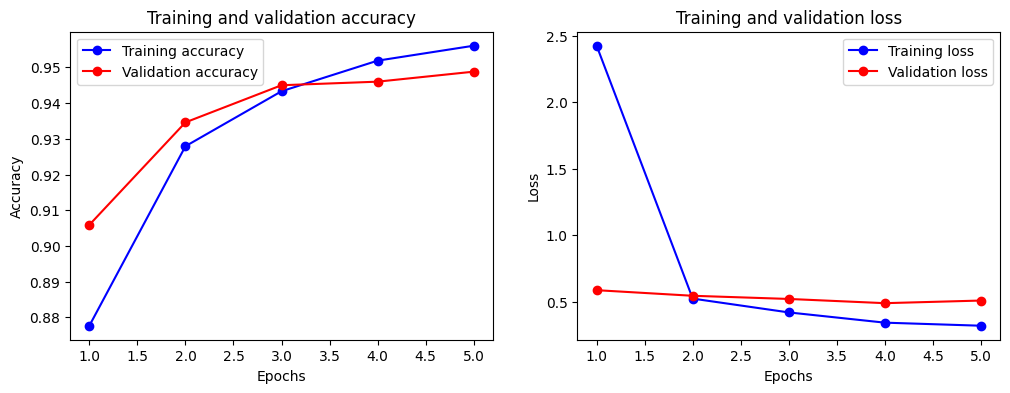

In [ ]:
# モデルをコンパイルする
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# モデルの学習
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# 学習曲線の描画
plot_learning_curve(history)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 128)               100480    
                                                                 
 dense_36 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


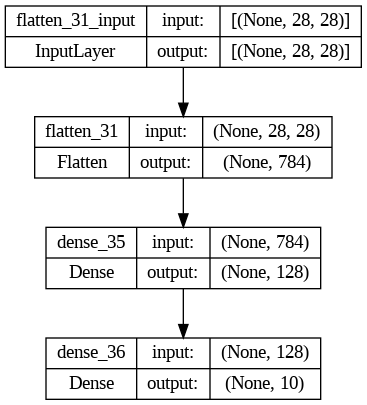

In [ ]:
# モデルの定義
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# モデルのサマリーを表示
model.summary()

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# モデルの学習
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# 学習曲線の描画
plot_learning_curve(history)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 27, 27, 28)        140       
                                                                 
 re_lu_2 (ReLU)              (None, 27, 27, 28)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 32)        3616      
                                                                 
 re_lu_3 (ReLU)              (None, 12, 12, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                

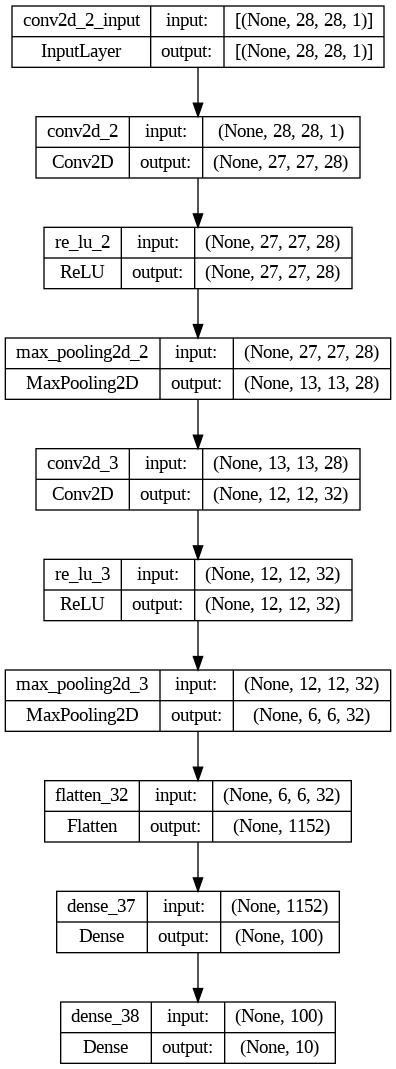

In [ ]:
# モデルの定義
model = Sequential([
    # (features): Sequential
    Conv2D(28, kernel_size=(2, 2), strides=(1, 1), input_shape=(28, 28, 1)),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(32, kernel_size=(2, 2), strides=(1, 1)),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # 全結合
    Flatten(),

    # (classifier): Sequential
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

# モデルのサマリーを表示
model.summary()

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

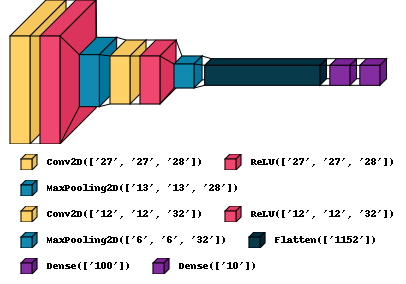

In [ ]:
# 立体的に可視化してみよう
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
# モデルのコンパイル
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# モデルの学習
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# 学習曲線の描画
plot_learning_curve(history)

In [ ]:
!pip install gradio==4.29.0

In [ ]:
import gradio as gr
import numpy as np

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0  # Normalize the image to range [0, 1]
    return normalized_image

# Define the prediction function
def classify(sketch):
    image = sketch["composite"]
    grayscale_image = np.mean(image, axis=2)  # Average across RGB channels

    # Resize and normalize the image
    resized_image = reshape_to_28x28(grayscale_image)

    # Convert the image to the correct shape for the model
    reshaped_image = resized_image.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

    # Make predictions and convert the result to a list
    pred = model.predict(reshaped_image).tolist()[0]

    # Get the top 3 predictions
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # Store confidences in a dictionary
    confidences = {str(i): v for i, v in zip(indices, values)}

    return confidences

# Gradioインターフェースを作成
gr.Interface(
    fn=classify,
    inputs="sketchpad",
    outputs="label",
).launch(debug=True)

# CNNネットワークの定義

## LeNet-5っぽいネットワークを定義してみる
[LeNet の構造](https://cvml-expertguide.net/terms/dl/cnn-backbone/lenet/)
- Lenet-5は、1998年にYann LeCunらがGradient-Based Learning Applied to Document Recognitionという研究論文で提案した、最も初期のモデルの1つ。
  - [畳み込み – 活性化関数 – プーリング層]の繰り返しにより、LeNetの前半が構成されている。
    - 畳み込み：特徴量を抽出するイメージ
    - 活性化層：活性化関数（ReLu、tanh、step、sigmoid、等）により、特徴量をフィルタリングするイメージ
    - プーリング層：解像度を下げてボカすイメージ
    - <img src="https://betashort-lab.com/wp-content/uploads/2018/07/1523891796216.jpg"  width="600" alt="サンプル画像" align="top" >
    - 参考：[An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)
    - <img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-ja.jpeg?69ac778e9cc7f76daa731a16801b4232"  width="600" alt="サンプル画像" align="top" >
    - 参考：[畳み込みニューラルネットワーク チートシート](https://stanford.edu/~shervine/l/ja/teaching/cs-230/cheatsheet-convolutional-neural-networks)
- 参考：[ConvNet計算機1](https://zimonitrome.github.io/convolution-shape-calculator/)
- 参考：[ConvNet計算機2](https://madebyollin.github.io/convnet-calculator/)
<br>
<br>
- Lenet-5は、次のような層構成である。
    - 最初の層は入力層で、特徴マップのサイズは32X32X1である。（今回のデータセットでは28x28x1）
    - 次の層は、サイズ5X5、ストライド1の6つのフィルタを持つ第1畳み込み層（この層で使用される活性化関数は、tanh）（今回はデータセットに合わせてカーネルサイズは1x1）
    - 次の層は、フィルターサイズ2X2、ストライド1のプーリング層
    - 次の層は、5X5、ストライド1の16個のフィルタを持つ第2番目畳み込み層（この層で使用される活性化関数は、tanh）
    - 次の層は、2X2、ストライド2のプーリング層
    - 次の層は、プーリング層は、5X5、ストライド1、活性化関数tanhの120個のフィルターであり、これで出力サイズは120となる。
    - 平滑化層：上記の層の出力結果を全て結合する（Fully Connected、線形層(Linear layer)や、密接続層(dense connection layer)とも）
    - 次の層は、84個のニューロンを持つ完全接続層で、出力は84値になり、ここで使用される活性化関数は再びtanhである。
    - 最後の層は出力層で、10個のニューロンを持ち、Softmax関数が使用されている。
<br>
<br>
- 以上が、Lenet-5モデルの全アーキテクチャであり、このアーキテクチャの学習可能なパラメータの数は、およそ6万個である。

In [ ]:
# LeNet-5っぽいネットワークを定義してみる
class LeNet5(nn.Module):
    # ニューラルネットワーク層を初期化する
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        # ここからネットワーク定義
        # 特徴量を取り出すfeaturesを定義
        self.features = nn.Sequential(
            # inputチャンネル数:1、outputチャンネル数:6、カーネルサイズ5の畳み込み
            nn.Conv2d(1, 6, kernel_size=1, stride=1),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # カーネルサイズ2のAveragePooling
            nn.AvgPool2d(kernel_size=2, stride=2),
            # inputチャンネル数:1、outputチャンネル数:16、カーネルサイズ5の畳み込み
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # カーネルサイズ2のAveragePooling
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # 分類結果を出力するclassifierを定義
        self.classifier = nn.Sequential(
            # 400個の長さの配列を120個に線形変換
            nn.Linear(400, 120),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # 120個の長さの配列を84個に線形変換
            nn.Linear(120, 84),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # 120個の長さの配列を10個に線形変換
            nn.Linear(84, 10)
        )

    # forwardにて、実際の入力データを演算する
    def forward(self, x):
        # 特徴量を取り出すfeaturesを呼び出し
        x = self.features(x)
        # 16*5*5の次元を、400の連続的な配列に変換する
        x = torch.flatten(x,1)
        # 分類結果を出力するclassifierを呼び出し
        logit = self.classifier(x)
        return logit

In [ ]:
net = LeNet5()
print(net)

In [ ]:
# ネットワーク可視化（縦×横が28×28のチャンネル1の画像を1枚入れたときの挙動を確認）
summary(net, (1, 1, 28, 28))

In [ ]:
# 指定したdevice（CPUもしくはGPU）にネットワークを転送
net = net.to(device)

## 損失関数および最適化関数の定義
---

In [ ]:
#学習するための関数を定義
def learn_network(net,epc=3):
    # 交差エントロピー誤差関数
    loss_func = nn.CrossEntropyLoss()
    # 今回はAdam(移動平均計算や学習率の調整により振動を抑制させる手法)を利用
    optimizer = optim.Adam(net.parameters())

    train_loss_track = []
    test_loss_track = []
    # エポックは今回「3」で設定
    for epoch in range(epc):
        running_loss = 0
        running_train_loss = 0
        running_test_loss = 0

        # 学習モード
        net.train()
        for batch_idx, (xx, yy)  in enumerate(train_loader):
            xx = xx.to(device)
            yy = yy.to(device)
            optimizer.zero_grad()
            y_pred = net(xx)
            loss = loss_func(y_pred, yy)
            loss.backward()
            optimizer.step()
            # 学習データを使って損失を計算
            running_loss += loss.item()
            running_train_loss += loss.item()
            if (batch_idx+1) % 100 == 0:
                print('[', epoch+1, ',',batch_idx+1, ']','loss: ', running_loss / 100)
                running_loss = 0.0
        # エポックが終了したら平均損失を計算
        train_loss_track.append(running_train_loss / (batch_idx + 1))

        # 評価（evaluation）モード ※詳細は後述
        net.eval()
        with torch.no_grad():  # 誤差逆伝播法を使った傾きの計算を無効にする設定で、メモリ消費量を削減できるメリットがある（推論時はパラメータの更新をしないため）
            for batch_idx, (xx_test, yy_test)  in enumerate(test_loader):
                xx_test = xx_test.to(device)
                yy_test = yy_test.to(device)
                # 予測値を計算
                y_pred = net(xx_test)
                # 誤差関数を使ってギャップの計測
                test_loss = loss_func(y_pred, yy_test)
                # テストデータを使って損失を計算
                running_test_loss += test_loss.item()
            # 誤差をトラッキング
            test_loss_track.append(running_test_loss / (batch_idx + 1))

    return net, train_loss_track


# 正解率を計算し・混同行列を可視化する関数
def calc_accuracy_and_show_cm(net):
    true = 0
    total = 0

    all_labels = np.array([])
    all_preds = np.array([])
    with torch.no_grad():
        for test_xx, test_yy in test_loader:
            # device = "cuda"の場合、GPUにデータを転送する
            test_xx = test_xx.to(device)
            test_yy = test_yy.to(device)
            outputs = net(test_xx)
            # torch.max()の出力は2つですが、1つ目の値は利用しないため、それを明示するために変数「_」を利用
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
            all_preds = np.append(all_preds, predicted.cpu().numpy())
            total += test_yy.size(0)
            true += (predicted == test_yy).sum().item()
    print('Accuracy: ', 100 * float(true/total), '%')

    print('\nConfusion Matrix:')
    labels = np.unique(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    display(pd.DataFrame(cm, columns=labels, index=labels))

    return all_labels, all_preds

# モデル学習と精度評価

## 学習  
フィードフォワード計算 → アウトプットと正解ラベルとの誤差計算 → 誤差逆伝搬法を使って自動微分 → パラメータ（重みなど）更新、を繰り返して学習させる

In [ ]:
net, train_loss_track = learn_network(net)

### 誤差の推移

In [ ]:
plt.plot(train_loss_track)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## テストデータにおける精度評価

- Accuracyを計算  
  - Accuracyとは全体のデータ数に対して予測と正解のラベルが一致した数の割合
- 混同行列（Confusion Matrxi）を可視化

In [ ]:
all_labels, all_preds = calc_accuracy_and_show_cm(net)

### 誤認識した画像の確認

In [ ]:
# 間違った画像のindex
np.where(all_labels != all_preds)

In [ ]:
# 間違った画像のindexから1つ確認
i = 0
idx = np.where(all_labels != all_preds)[0][i]
plt.imshow(testset.data[idx], cmap='gray')
print("Label : ", all_labels[idx])
print("Pred  : ", all_preds[idx])